# Principal Component Analysis

Principal component analysis (PCA) is a dimensionality reduction technique. This notebook will cover the maths and implementation of PCA.

## 1. Steps to implementing PCA

1. Compute the covariance matrix of the data:

$$ \Sigma = \frac{1}{m} X^T X$$

2. Perfome singular value decomposition to obtain the eigenvectors(`U`) and eigenvalues(`S`): `U, S, V = np.linalg.svd(Sigma)`.

3. Projects the data onto a new subspace with equal or fewer dimensions than the original one:

$$ X' = XU_{reduced} $$

> were $X$ is the origianal data, $X'$ is the projected data, $U_{reduced}$ is the reduced eigenvectors used for projection.

4. If an approximate representation of the data ($X^{*}$) is needed, the projected data ($X'$) can be inverse transformed as:

$$ X^{*} = X'U_{reduced}^{T} $$


## 2. Implementation

In [1]:
import numpy as np

In [2]:
class PCA():
    """
    X : array_like
        (m, n) where m is the number of training examples 
        and n is the number of features
    """
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None
        self.eigenvalues = None
        
    def normalize_feature(self, X):
        return (X - self.mean) #/ self.std
    
    def fit(self, X):
        # dimensions of X array
        m, n = X.shape
        
        # calculate stats
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
        # perform feature normalization
        X_norm = self.normalize_feature(X)
        
        # calculate covarient matrix
        cov_mat = 1/m * X_norm.T.dot(X_norm)
        
        # perform singular value decomposition
        self.eigenvectors, self.eigenvalues, _ = np.linalg.svd(cov_mat)
        self.eigenvalues = self.eigenvalues[:self.n_components]
        self.eigenvectors = self.eigenvectors[:, :self.n_components]
        
    def transform(self, X):
        # perform feature normalization
        X_norm = self.normalize_feature(X)
        
        return X_norm.dot(self.eigenvectors)
    
    def inverse_transform(self, Z):
        """ Z: The PCA tranformed data. Shape = (m x n_components) """
        return np.dot(Z, self.eigenvectors.T)
        

## 3. Example

In [3]:
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
# helper function for ploting images
def plot_images(m, images, titles, h, w):
    
    n_rows = int(np.floor(np.sqrt(m)))
    n_cols = int(np.ceil(m / n_rows))
    
    figsize=(6, 6)
    fig, ax_array = plt.subplots(n_rows, n_cols, figsize=figsize)
    ax_array = ax_array.ravel()
    for i, ax in enumerate(ax_array):
        ax.imshow(images[i].reshape(h, w), cmap='gray')
        ax.axis('off')
        ax.set_title(titles[i])

In [5]:
# load the "Labeled Faces in the Wild" dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [6]:
# extract info
n_samples, h, w = lfw_people.images.shape
target_names = lfw_people.target_names

# X and y => images and labels
X = lfw_people.data
y = lfw_people.target

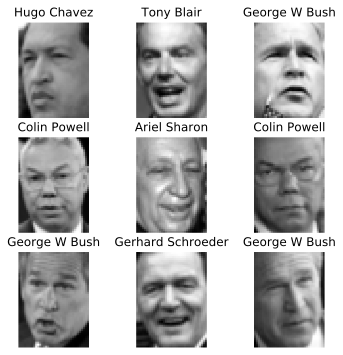

In [7]:
# plot some images
m = 9
titles = [target_names[i] for i in y]
plot_images(m, X, titles, h, w)

In [8]:
# initialize PCA
n_features = X.shape[1]
n_components = 150
pca = PCA(n_components)

In [9]:
# perform PCA
t0 = time()
pca.fit(X)
X_pca = pca.transform(X)
print("done in %0.3fs" % (time() - t0))

done in 2.918s


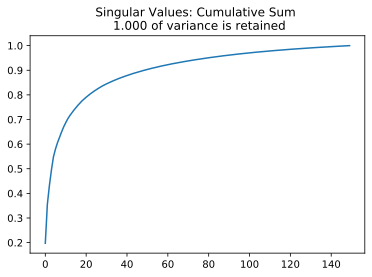

In [10]:
# evaluate PCA
cum_sum = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.plot(cum_sum)
plt.title("Singular Values: Cumulative Sum \n %0.3f of variance is retained" % cum_sum[-1])
plt.show()

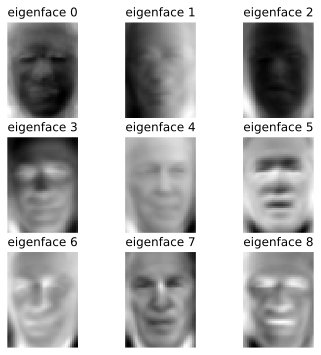

In [11]:
# plot eigenfaces
eigenfaces = pca.eigenvectors.T.reshape((n_components, h, w))
m = 9
eigenfaces_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_images(m, eigenfaces, eigenfaces_titles, h, w)

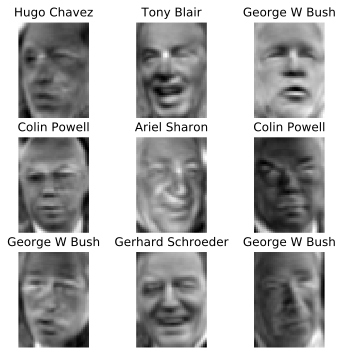

In [12]:
# plot recovered faces
X_recovered = pca.inverse_transform(X_pca)

m = 9
titles = [target_names[i] for i in y]
plot_images(m, X_recovered, titles, h, w)

In [13]:
# probe dimensions
print(X.shape, X_pca.shape)

(1288, 1850) (1288, 150)


From this example, the power of PCA in reducing the dimension of data can be seen. The dimension of the images was reduced from 1850 to 150 while retaining 100% of the varience. This reduced dimension data can then be used to classify the images with considerable speedup.